# Ex 5: Simple and multiple linear regression analysis


**Background**

In regression analysis a relation is made between a dependent variable $Y$ (i.e. the one one wants to estimate) and one or a number of independent variables $X_i$. The objective(s) of establishing a regression model may be manifold, like:
1. Making forecasts/predictions/estimates on Y based on data of the independent variable(s)
2. Investigation of a functional relationship between two or more variables
3. Filling in missing data in the Y-series
4. Validation of Y-series

**Simple Linear Regression**

Simple linear regression is an approach for predicting a quantitative response using a single feature (or "predictor" or "input variable"). It takes the following form for one independent variable:

$y = \alpha + \beta x $

 - $y$ is the response or the dependent variable
 - $x$ is the independent variable
 - $\alpha$ is the intercept
 - $\beta$ is the slope or the trend

Together, $\alpha$ and $\beta$ are called the model coefficients. To create your model, you must find the values of these coefficients.

**Multiple Linear Regression**

Multiple linear regression is an approach for predicting a quantitative response using a multiple features (or "predictors" or "input variables"). It takes the following form for the $p$ independent variables $X_i$ where $i=1,2,..,p$:

$\hat{y} = \beta_0 + \sum_{i=1}^{p}{\beta_i x_i}$

$ = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdot \cdot \cdot + \beta_px_p$

 - $\hat{y}$ is the response or the dependent variable
 - $x_i$ is the independent variable number $i$
 - $\beta_0$ is the intercept
 - $\beta_i$ is the coefficient for $x_i$
 - $p$ is the number of independent variables

Notice that for $p$=1 (one independent variable), the equation becomes the simple linear regression (where $\alpha=\beta_0$ and $\beta=\beta_1$).

In [1]:
import statsmodels.formula.api as smf  # module to run ordinary least squares analysis
# how to create a fitted model:
#linfit = smf.ols(formula='dep_var ~ ind_var', data=df).fit()

# examples of how to get results:
#print(linfit.summary()) #summary table of the regression analysis
#print(linfit.params)
#print(linfit.rsquared)
#print(linfit.bse)
#print(dir(linfit)) #for all possible attributes

# where:
# dep_var = dependent variables
# ind_var = independent variables
# df = dataframe with column dep_var and ind_var

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

### Question 1: Simple linear regression

Temperature data for November 1977 is available from Falun (Dalarna), Gävle (Gästrikland) and Knon (Värmland) in the file *temp_falun.dat*. For Falun the data series is not complete.

We want to fill the missing data for Falun using the best correlated data set of the three possible data sets:

1. Only the data from Gävle 
2. Only the data from Knon
3. Both Gävle and Knon and the information about distances (Gävle-Falun $ =82$ km, Knon-Falun $ =110$ km)

*Hint: inverse distance weighting method can be used to create the third dataset.*

$T_{Gavle+Knon} = \frac{\left(\frac{1}{82}\right)^2}{\left(\frac{1}{82}\right)^2 + \left(\frac{1}{110}\right)^2}T_{Gavle} + \frac{\left(\frac{1}{110}\right)^2}{\left(\frac{1}{82}\right)^2 + \left(\frac{1}{110}\right)^2}T_{Knon}$  (1)

In [2]:
# Reading in the temperature data from Falun, Gävle and Knon
T_data = pd.read_csv('temp_falun.dat', index_col = 0, sep='\t')
T_data.head()

,T_Falun,T_Gavle,T_Knon
Day,,,
1,8.2,9.0,6.5
2,6.4,7.8,4.8
3,5.9,5.7,5.5
4,6.3,6.6,5.6
5,2.8,4.5,3.4


**a)** Compute the correlation between Falun and (1), (2) and (3) and determine which one shall be used as the independent variable.

In order to find the correlation between the temperature at Falun and the two other places around, I find the Pearson correlation coefficient. This is because I assume that the relationships between the temperature are likely to be linear, and the Pearson coefficient gives me the linear correlation. The same goes for the correlation between Falun and the dataset composed of temperatures from both places, weighted with distance. 

In [3]:
N = len(T_data['T_Falun'].dropna())

# Pearson Correlation Coefficient between the data from Falun and Gävle

corr_G_F = st.pearsonr(T_data['T_Falun'].dropna(), T_data['T_Gavle'].loc[:N])

# Pearson Correlation Coefficient between the data from Falun and Knon

corr_K_F = st.pearsonr(T_data['T_Falun'].dropna(), T_data['T_Knon'].loc[:N])

# Pearson Correlation Coefficient between the data from Falun and the data from both Gävle and Knon
# (weighted with distance)

GFdist = 82 # Distance between Gävle and Falun [km]
KFdist = 110 # Distance between Knon and Falun [km]

# Using inverse distance weighting method
A = (1./GFdist)**2
B = (1./KFdist)**2
T_data['T_Gavle_Knon'] = A/(A + B)*T_data['T_Gavle'] + B/(A + B)*T_data['T_Knon']

corr_G_K_F = st.pearsonr(T_data['T_Falun'].dropna(), T_data['T_Gavle_Knon'].loc[:N])

print('The Pearson correlation coefficient is:')
print('%.3f between the temperature at Falun and at Gävle.' %corr_G_F[0])
print('%.3f between the temperature at Falun and at Knon.' %corr_K_F[0])
print('%.3f between the temperature at Falun and the temperature and both Gävle and Knon, weighted with distance.' %corr_G_K_F[0])

The Pearson correlation coefficient is:
0.984 between the temperature at Falun and at Gävle.
0.970 between the temperature at Falun and at Knon.
0.993 between the temperature at Falun and the temperature and both Gävle and Knon, weighted with distance.


The correlation coefficient varies between -1 and 1, where 1 maximum correlation and -1 is maximum anti-correlation, while 0 is no correlation. I see the that all the temperatures have high correlation. Falun has higher correlation wiht Gävle than with Knon, which is expected as Falun is closer to Gävle than to Knon. The highest correlation is between Falun and the temperature and both Gävle and Knon, weighted with distance.

**b)** For each of the three independent variables: Fit a regression model and state the regression coefficients and how much of the variance is explained by each model, i.e. the $R^2$ values. Which model has the highest $R^2$ value? Select that model for the next part of the analysis.

*Hint: For the evaluation the coefficient of determination $R^2$ is used. It is defined as $ R^2 = \frac{\text{explained variance}}{\text{total variance}}$. You'll find this value in the upper right corner of the summary table.*

In [4]:
# Linear regression and explained variance between the data from Falun and Gävle

G_linfit = smf.ols(formula='T_Falun ~ T_Gavle', data=T_data).fit()
R2_G = G_linfit.rsquared
print('The temperature F at Falun relates to the temperature T at Gävle as:')
print('F = %.2f + %.2fT' %(G_linfit.params[0],G_linfit.params[1]), ', with an explained variance R² = %.3f.\n' %R2_G)

# Linear regression and explained variance between the data from Falun and Knon

K_linfit = smf.ols(formula='T_Falun ~ T_Knon', data=T_data).fit()
R2_K = K_linfit.rsquared
print('The temperature F at Falun relates to the temperature T at Knon as:')
print('F = %.2f + %.2fT' %(K_linfit.params[0],K_linfit.params[1]), ', with an explained variance R² = %.3f.\n' %R2_K)


# Linear regression and explained variance between the data from Falun and the data from both Gävle and Knon

G_K_linfit = smf.ols(formula='T_Falun ~ T_Gavle_Knon', data=T_data).fit()
R2_G_K = G_K_linfit.rsquared
print('The temperature F at Falun relates to the variable T of temperatures from both Gävle and Knon as:')
print('F = %.2f + %.2fT' %(G_K_linfit.params[0],G_K_linfit.params[1]), ', with an explained variance R² = %.3f.' %R2_G_K)

The temperature F at Falun relates to the temperature T at Gävle as:
F = -0.40 + 0.93T , with an explained variance R² = 0.967.

The temperature F at Falun relates to the temperature T at Knon as:
F = 1.29 + 0.83T , with an explained variance R² = 0.941.

The temperature F at Falun relates to the variable T of temperatures from both Gävle and Knon as:
F = 0.19 + 0.92T , with an explained variance R² = 0.987.


The variable consisting of temperatures from both Gävle and Knon, weighted with distance, has the highest explained variance R². I therefore use this variable to make a fit for the missing data at Falun.

In [5]:
T_Falun_fitted = G_K_linfit.params[0] + G_K_linfit.params[1]*T_data['T_Gavle_Knon']

T_data['T_Falun_fitted'] = T_Falun_fitted
T_data.head()

,T_Falun,T_Gavle,T_Knon,T_Gavle_Knon,T_Falun_fitted
Day,,,,,
1,8.2,9.0,6.5,8.106991,7.624316
2,6.4,7.8,4.8,6.728389,6.359258
3,5.9,5.7,5.5,5.628559,5.350011
4,6.3,6.6,5.6,6.242796,5.913659
5,2.8,4.5,3.4,4.107076,3.953839


**c)** Test the significance of $\beta$, i.e. the regression coefficient representing the slope. State your hypotheses, degrees of freedom, test statistic value, rejection criteria and conclusion.

*Hint: You can use a two-sided t-test to test if the slope is significantly different from zero. When calculating the test statisic, the standard error (used in the denominator) is the 'std err' given in the summary table of the regression analysis .*

In testing the significance of the regression coefficient representing the slope, $\beta$, my null hypothesis is that it is not significant. This corresponds to that the slope in the relationship between the varibles is zero or close to zero. I use the variable with the highest explained variance, which I found in the last exercise. The test statistic I use is $\beta$ minus the slope of the null hypothesis (zero), divided by the standard deviation of $\beta$. I get the value of the standard deviation of $\beta$ from the summary table of the linear fit. I use a two-sided t-test, and my test criterion is that the absolute value of the test statistic should be larger than a certain t-value, given by the significance level and the degrees of freedom. I choose a significance level of $\alpha = 0.05$. Since I have a linear fit with one variable, the number of degrees of freedom is $N-2$, where $N$ is the number of observations.

Null hypothesis: That our beta is not significant, the slope is zero or close to zero.

Test statistic: $T = \frac{\beta-0}{s_{\beta}}$

Rejection criterion: $|T| \geq t_{1-\alpha/2, n-2}$

In [6]:
print(G_K_linfit.summary())

                            OLS Regression Results                            
Dep. Variable:                T_Falun   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1393.
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           3.06e-19
Time:                        11:09:39   Log-Likelihood:                -16.407
No. Observations:                  21   AIC:                             36.81
Df Residuals:                      19   BIC:                             38.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1850      0.135      1.375   

In [7]:
N = len(T_data['T_Falun'].dropna())
beta = G_K_linfit.params[1]
s_beta = 0.025 # from summary table
df = N-2
alfa = 0.05
T = beta/s_beta
t = st.t.ppf(1 - alfa/2, df)
print('The absolute value of the test statistic is %.2f' %abs(T))
print('The critical t-score is %.2f' %t)

The absolute value of the test statistic is 36.71
The critical t-score is 2.09


Conclusion: since $|T| \geq t_{1-\alpha/2, n-2}$, I reject the null hypothesis. We conclude that the slope $\beta$ is significant.

**d)** In the same figure, plot the time series of the observed data at the three stations together with the estimated temperature at Falun using the best model.

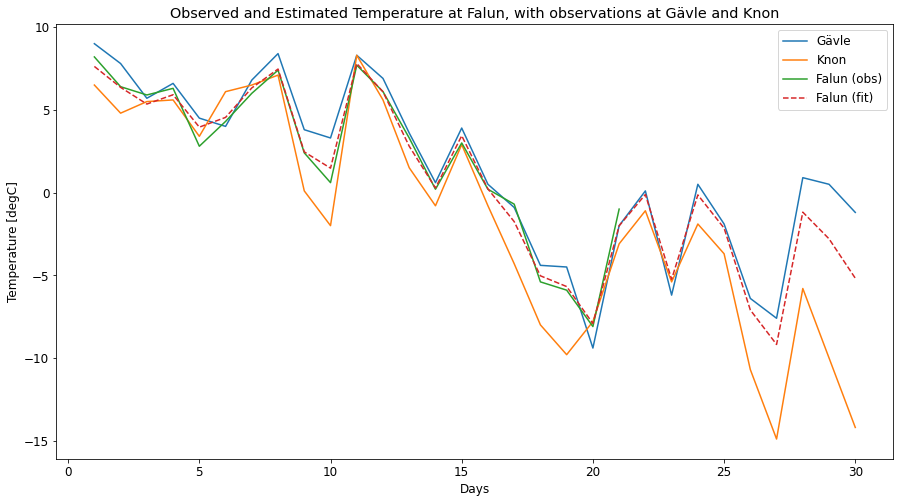

In [8]:
plt.figure(figsize=[15,8])
plt.rc('font', size=12)   
plt.plot(T_data['T_Gavle'],label='Gävle')
plt.plot(T_data['T_Knon'],label='Knon')
plt.plot(T_data['T_Falun'],label='Falun (obs)')
plt.plot(T_data['T_Falun_fitted'], label='Falun (fit)',linestyle='--')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Temperature [degC]')
plt.title('Observed and Estimated Temperature at Falun, with observations at Gävle and Knon')
plt.show()

### Question 2: Multiple linear regression

In a **standard multiple linear regression**, all the independent variables are used in the regression model. Disadvantages of including all independent variables may include high cost of collecting all the data, including variables that do not improve the fit, and overfitting (making the model worse in predicting new data points).

That is why we introduce **forward selection** (or similar proceedures). By this method, we can start by performing a simple regression using the independent variable which has the highest correlation with the dependent variable. Then, add another independent variable, and make sure that this second independent variable should have the highest partial correlation with the dependent while the influence of the first independent variable is removed. Continue this procedure to see if the addition of a third independent variable will be helpful. 

In [9]:
# Reading the multidata file
data = pd.read_csv('multidata.txt',sep='\t')
data.head()

,X1,X2,X3,Y
0,1,2,10,5.077
1,2,2,9,32.330
2,3,3,5,65.140
3,4,4,4,47.270
4,5,2,9,80.570


**a)** In the file *multidata.txt* there are a number of numerical variables. Choose Y as the dependent variable and X1, X2, X3 as the independent variables. Perform a multiple linear regression using forward selection (in compendium called stepwise multiple regression) method. State in each step the choices you make, the reasons behind them, and the values you calculate (which the choices are based on).

I will perform a multiple linear regression in order to find the best model for Y, using the independent variables X1, X2 and X3. I will do that by starting with performing a simple regression (using one variable), and then add others depending on whether they improve the model. To choose which variable to begin with, I find the one with the highest correlation.

In [10]:
corr_X1_Y = st.pearsonr(data['X1'],data['Y'])[0]
corr_X2_Y = st.pearsonr(data['X2'],data['Y'])[0]
corr_X3_Y = st.pearsonr(data['X3'],data['Y'])[0]
print('The correlation between Y and X1 is %.3f.' %corr_X1_Y)
print('The correlation between Y and X2 is %.3f.' %corr_X2_Y)
print('The correlation between Y and X3 is %.3f.' %corr_X3_Y)

The correlation between Y and X1 is 0.624.
The correlation between Y and X2 is 0.265.
The correlation between Y and X3 is 0.587.


Y has highest correlation with X1. I choose this as the first independent variable. I make a linear fit and examine the explained variance and adjusted explained variance by printing out the summary table of the fit.

In [11]:
Y_X1_linfit = smf.ols(formula='Y ~ X1', data=data).fit()

The summary table can be found further down, under exercise b). The linear fit is on the following form:

$$Y = 9.996 + 11.983X_1$$

with an explained variance $R^2 = 0.390$ and an adjusted explained variance $R_{adj}^2 = 0.349$.

I now want to find out which remaining variable has the highest partial correlation with Y (the best correlation with Y after excluding correlation with X1). This is the one I want to add to the model to see if it improves the model.

In [12]:
# Partial correlation between X2 and Y without X1
corr_X1_X2 = st.pearsonr(data['X1'],data['X2'])[0]
pcorr_X2_Y = (corr_X2_Y - corr_X1_Y*corr_X1_X2)/np.sqrt((1-corr_X1_X2**2)*(1-corr_X1_Y**2))
print('The partial correlation between Y and X2 is %.3f.' %pcorr_X2_Y)

# Partial correlation between X3 and Y without X1
corr_X1_X3 = st.pearsonr(data['X1'],data['X3'])[0]
pcorr_X3_Y = (corr_X3_Y - corr_X1_Y*corr_X1_X3)/np.sqrt((1-corr_X1_X3**2)*(1-corr_X1_Y**2))
print('The partial correlation between Y and X3 is %.3f.' %pcorr_X3_Y)

The partial correlation between Y and X2 is 0.378.
The partial correlation between Y and X3 is 0.874.


X3 has the highest partial correlation with Y without X1, so choose this as my second independent variable. I make a linear fit for Y with two independent variables X1 and X3. I read the parameters and the explained variances off the summary table, which can be found further down under exercise b).

In [13]:
Y_X1_X3_linfit = smf.ols(formula='Y ~ X1 + X3', data=data).fit()

The linear fit is on the following form:

$$Y = -14.223 + 13.878X_1 + 1.350X_3$$

with an explained variance $R^2 = 0.856$ and an adjusted explained variance $R_{adj}^2 = 0.836$.

We see that the explained variances are considerably higher for this model than for the previous one. However, we can use an F-test to test the significance of our added variable. We perform the F-test by checking if our test statistic $F_c$:

$$F_c = \frac{(1-R^2_{n-1})(N-n-1)}{(1-R^2_{n})(N-n-2)}$$

is higher than a certain F-distribution value $F_{1-\alpha, N-n-1, N-n-2}$. Here $\alpha$ is the signifance level (5 %), $N$ is the number of observations, and $n$ is the number of independent variables. 

In [14]:
N = len(data['Y'])
n = 2
alfa = 0.05
R2_Y_X1 = Y_X1_linfit.rsquared
R2_Y_X1_X3 = Y_X1_X3_linfit.rsquared

Fc = (1 - R2_Y_X1)*(N-n-1)/((1 - R2_Y_X1_X3)*(N-n-2))
F = st.f.ppf(1-alfa, N-n-1, N-n-2)
print('The test statistic F_c is %.3f.' %Fc)
print('The critical F-distribution value is %.3f.' %F)

The test statistic F_c is 4.575.
The critical F-distribution value is 2.554.


We have $F_c > F_{1-\alpha, N-n-1, N-n-2}$, which means that the addition of X3 is significant.

Lastly we want ot see if we can improve our model by adding a third variable X2. We perform a linear fit between all the variables. The summary table of the fit can be found further down, under exercise b).

In [15]:
Y_all_linfit = smf.ols(formula='Y ~ X1 + X2 + X3', data=data).fit()

The linear fit is on the following form:

$$Y = -22.826 + 13.910X_1 + 1.284X_2 + 3.993X_3$$

with an explained variance $R^2 = 0.873$ and an adjusted explained variance $R_{adj}^2 = 0.844$.

We see that the explained variances are slightly higher than before. We can do an F-test to see if the added variable is significant. The procedure isthe same as before, except that the number of independent variables is now three instead of two.

In [16]:
N = len(data['Y'])
n = 3
alfa = 0.05
R2_Y_all = Y_all_linfit.rsquared

Fc = (1 - R2_Y_X1_X3)*(N-n-1)/((1 - R2_Y_all)*(N-n-2))
F = st.f.ppf(1-alfa, N-n-1, N-n-2)
print('The test statistic F_c is %.3f.' %Fc)
print('The critical F-distribution value is %.3f.' %F)

The test statistic F_c is 1.227.
The critical F-distribution value is 2.660.


We have $F_c < F_{1-\alpha, N-n-1, N-n-2}$, which means that the addition of X2 is not significant.

**b)** Present in each case (for the model you make in each step) the $R^2$ and $R^2_{adj}$ values and the regression equations.

##### Summary table for linear fit between Y and X1

In [17]:
print(Y_X1_linfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     9.572
Date:                Mon, 12 Oct 2020   Prob (F-statistic):            0.00741
Time:                        11:09:40   Log-Likelihood:                -78.599
No. Observations:                  17   AIC:                             161.2
Df Residuals:                      15   BIC:                             162.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9956     14.461      0.691      0.5

/home/astridbg/Documents/geo4300/exercises/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


##### Summary table for linear fit between Y, and X1 and X3

In [18]:
print(Y_X1_X3_linfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     41.72
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           1.26e-06
Time:                        11:09:40   Log-Likelihood:                -66.303
No. Observations:                  17   AIC:                             138.6
Df Residuals:                      14   BIC:                             141.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.2231      8.102     -1.756      0.1

/home/astridbg/Documents/geo4300/exercises/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


##### Summary table for linear fit between Y, and X1 and X3

In [19]:
print(Y_all_linfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     29.81
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           4.27e-06
Time:                        11:09:40   Log-Likelihood:                -65.247
No. Observations:                  17   AIC:                             138.5
Df Residuals:                      13   BIC:                             141.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.8259     10.270     -2.223      0.0

/home/astridbg/Documents/geo4300/exercises/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


**c)** Present also your F-test results (use $\alpha$ = 5%)

See exercise a).

**d)** What are your conclusions, and why? Which model do you choose?

I choose the model where I only use X1 and X3 as independent variables:

$$Y = -14.223 + 13.878X_1 + 1.350X_3$$

because the addition of X2 was not significant. Even though the explained the variances where slightly higher for the last model, the difference in $R^2_{adj}$ between the models was not so large. To avoid overfitting, I therefore use the model with fewer independent variables.